In [455]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from time import process_time

def mirror_descent_momentum(A,iter,stepsize,omega,alpha):
    iter= iter
    stepsize=stepsize
    omega_m = omega
    n = omega.shape[0]
    for j in range(iter):
        omega_m = alpha*omega_m + np.matmul(A,omega)
        for i in range(n):
          omega[i]=omega[i]*np.exp(-stepsize*omega_m[i])
        omega = (1/omega.sum())*omega 
    #print(np.matmul(np.matmul(A,omega),omega),sum(i>0.1 for i in n*omega)/n)

    return omega 

class highDimensionGM():

    def __init__(self, dimension,omega, mean, var):
        self.dimension = dimension
        self.omega = omega
        self.mean = mean
        self.var = var

    def dlnprob(self, x):

        rep_x = np.tile(np.expand_dims(x,axis=1),(1,w.shape[0],1))
        category_prob = np.exp(- np.linalg.norm(rep_x-self.mean,axis=2)**2 / (2 * self.var)) / ((2 * np.pi * self.var)**(self.dimension/2)) * self.omega
        den = np.expand_dims(np.sum(category_prob, 1),axis=1)
        num = -(np.tile(np.expand_dims(category_prob,axis=2),(1,1,x.shape[1]))*(rep_x - self.mean)).sum(1)
        return num/den

    def MGprob(self, x):
        rep_x = np.tile(np.expand_dims(x,axis=1),(1,w.shape[0],1))
        category_prob = np.exp(- np.linalg.norm(rep_x-self.mean,axis=2)**2 / (2 * self.var)) / ((2 * np.pi * self.var)**(self.dimension/2)) * self.omega
        den = np.sum(category_prob,1)
        return np.expand_dims(den,1)

class SVGD_model():

    def __init__(self):
        pass


    def SVGD_kernal(self, x,beta, h=-1):
        d = x.shape[1]
        init_dist = pdist(x)
        pairwise_dists = squareform(init_dist)
        if h < 0:  # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = h ** 2 / np.log(x.shape[0] + 1)

        kernal_xj_xi = np.exp(- pairwise_dists ** 2 / h)#/ (( np.pi * h)**(1/2))
        d_kernal_xi = np.zeros([x.shape[0],d])
        for i_index in range(x.shape[0]):
            d_kernal_xi[i_index] = np.matmul(kernal_xj_xi[i_index], x[i_index] - x) * 2/h

        if beta == 0:
          return kernal_xj_xi, d_kernal_xi

        else:
        
          dd_kernal_xj_xi=np.zeros([x.shape[0],x.shape[0]])
          dd_kernal_xj_xi= np.multiply(kernal_xj_xi,2*d/h-4*pairwise_dists**2/h**2)

          return kernal_xj_xi, d_kernal_xi,dd_kernal_xj_xi,h

    def update(self, x0, lnprob,probdensity,beta, n_iter=1000, stepsize=1e-3,loop=20,tau=0.01,opt_step = 0.3,opt_iter=40, bandwidth=-1, debug=False,alpha=0.2,init_iter=200):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        x = np.copy(x0)
        n = x.shape[0]
        d = x.shape[1]
        gap=tau*np.ones(n)

        omega = 1/n*np.ones(n)
        stein_out = np.zeros(n_iter)
        time_out = np.zeros(n_iter)
        omega_out =np.zeros([n_iter,n])
        x_out = np.zeros([n_iter,n,d])

        for iter in range(n_iter):
            if debug and (iter + 1) % 1000 == 0:
                print('iter ' + str(iter + 1))
            gradmatrix = lnprob(x)

            omega_out[iter]=omega
        
            time_out[iter]=process_time()

            if beta==0:
              kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x,0, bandwidth)
              current_grad = (np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi) / n
              x += stepsize * current_grad
              x_out[iter]=x
              #print(x.sum(0)/x.shape[0])
      
              if iter == n_iter-1:
                kernal_xj_xi, d_kernal_xi,dd_kernal_xj_xi,h= self.SVGD_kernal(x,-0.5, bandwidth)

                d_kernal_xj_xi = np.zeros([n,n])
                for i_index in range(n):
                  d_kernal_xj_xi[i_index] = np.matmul(gradmatrix[i_index], (x[i_index] - x).transpose()) 
                d_kernal_xj_xi = np.multiply((d_kernal_xj_xi+d_kernal_xj_xi.transpose())* (2/h),kernal_xj_xi)
                SteinMatrix = np.multiply(kernal_xj_xi,np.matmul(gradmatrix,gradmatrix.transpose()))\
                +dd_kernal_xj_xi+d_kernal_xj_xi
                stein_out[iter] =np.matmul(np.matmul(SteinMatrix,1/n*np.ones(n)),1/n*np.ones(n)) 
                omega = mirror_descent_momentum(SteinMatrix,init_iter,opt_step,omega,alpha) 
            else:
              if iter%loop ==0 or iter <=1 or iter == n_iter-1:
                kernal_xj_xi, d_kernal_xi,dd_kernal_xj_xi,h = self.SVGD_kernal(x,beta, bandwidth)

                d_kernal_xj_xi = np.zeros([n,n])
                for i_index in range(n):
                  d_kernal_xj_xi[i_index] = np.matmul(gradmatrix[i_index], (x[i_index] - x).transpose()) 
                #d_kernal_xj_xi = (d_kernal_xj_xi+d_kernal_xj_xi.transpose())* (2/h)
                d_kernal_xj_xi = np.multiply((d_kernal_xj_xi+d_kernal_xj_xi.transpose())* (2/h),kernal_xj_xi)

                SteinMatrix = np.multiply(kernal_xj_xi,np.matmul(gradmatrix,gradmatrix.transpose()))\
                +dd_kernal_xj_xi+d_kernal_xj_xi
                
                # SteinMatrix1 = np.multiply(kernal_xj_xi,np.matmul(gradmatrix,gradmatrix.transpose()))\
                #  +dd_kernal_xj_xi+d_kernal_xj_xi1
                stein_out[iter] =np.matmul(np.matmul(SteinMatrix,1/n*np.ones(n)),1/n*np.ones(n)) 
                omega = mirror_descent_momentum(SteinMatrix,opt_iter,opt_step,omega,alpha) 
              else:
                kernal_xj_xi, d_kernal_xi = self.SVGD_kernal(x,0, bandwidth)


              #current_grad = np.multiply(np.mat((n*omega+tau)**(beta)).transpose(),(np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi)) / n
              current_grad = np.multiply(np.mat((np.maximum(n*omega,gap))**(beta)).transpose(),(np.matmul(kernal_xj_xi, gradmatrix) + d_kernal_xi)) / n
              #print(np.maximum(n*omega,tau*np.ones(n)))
              x += stepsize * current_grad
              #print(x.sum(0)/x.shape[0])
              x_out[iter]=x
        return x_out,stein_out,omega_out,time_out




if __name__ == "__main__":

    dimension = 2
    # w = np.array([1])
    # mean = np.array([2]+[0 for i in range(dimension-1)])
    # var = np.array([1])
    w = np.array([0.4,0.2,0.4])
    mean = np.array([[2]+[0 for i in range(dimension-1)],[4]+[0 for i in range(dimension-1)],[3]+[-3 for i in range(dimension-1)]])
    var = np.array([1,1,1])

    highDimensionGM_model = highDimensionGM(dimension,w, mean, var) 
    dlnprob = highDimensionGM_model.dlnprob
    probdensity=highDimensionGM_model.MGprob
    svgd_model = SVGD_model()

    
    num_particle = 1000

    n_iter = 401
    loo=1
    yy= np.array([-2]+[0 for i in range(dimension-1)])
    

    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    # x,stein,omega,time = svgd_model.update(x0, dlnprob, probdensity, beta=-0.5, n_iter=n_iter, stepsize=0.2,loop=20,tau=0.01,opt_step = 0.3, opt_iter=40, \
    #                             bandwidth=dimension , debug=True,alpha=0.2,init_iter=40)

    # #plot result
    # sns.kdeplot(x.reshape((num_particle,)), bw = .4, color = 'g')

    # mg_prob = highDimensionGM_model.MGprob
    # x_lin = np.expand_dims(np.linspace(-15, 15, 100), 1)
    # x_prob = mg_prob(x_lin)
    # plt.plot(x_lin, x_prob, 'b--')
    # plt.axis([-15, 15, 0, 0.4])
    # plt.title(str(n_iter) + '$ ^{th}$ iteration, '+'beta='+str(beta))
    # plt.show()

#iter=20, out_stepsize=0.5, inner_stepsize=5,inner_iter=100 achieve very good results.

#iter=500, stepsize=1.1,inner_stepsize=5,inner_iter=20 is stable than 0-SVGD with stepsize=11, \
#while when stepsize=12 for SVGD(it will diverge) and stepsize=1.2 for stein -0.5-SVGD(converge)
#200 particle,when stepsize=1 for stein -0.5-SVGD , 500 iterations,it can produce nice results, but for SVGD with stepsize=10, the result is bad
#100 particles, step=0.9 for stein SVGD 100 iterations better than SVGD with step=9 and iter=100(SVGD is not stable, more iterations will make the results worse） 


In [403]:
np.random.seed(4000)
x_ab = np.zeros([loo,n_iter])
x_ab_mean = np.zeros([loo,n_iter])

a = [9.4]+[4.6 for i in range(dimension-1)]
b= [2.8]+[-1.2 for i in range(dimension-1)]
for i in range(loo):
                    
    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    beta =-0
   
    x,stein,omega,time = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.1,loop=0.1,tau=0.01,opt_step = 0.3, opt_iter=40, \
                                bandwidth=dimension , debug=True,alpha=0.2,init_iter=40)
    
    for j in range(x.shape[0]):
        x_ab[i][j]=abs(((x*x)[j]).sum(0)/x[j].shape[0]-a).sum(0)
        x_ab_mean[i][j]=abs((x)[j].sum(0)/x[j].shape[0]-b).sum(0)
variances = (x_ab.sum(0))/loo
means = (x_ab_mean.sum(0))/loo       


In [404]:
np.random.seed(400)
x_ab1 = np.zeros([loo,n_iter])
x_ab_mean1 = np.zeros([loo,n_iter])

a = [9.4]+[4.6 for i in range(dimension-1)]
b= [2.8]+[-1.2 for i in range(dimension-1)]
for i in range(loo):
                    
    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    beta =-0.5
   
    x1,stein1,omega1,time1 = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.1,loop=20,tau=0.01,opt_step = 0.3, opt_iter=40, \
                                bandwidth=dimension , debug=True,alpha=0.2,init_iter=40)
    
    for j in range(x1.shape[0]):
        x_ab1[i][j]=abs(((x1*x1)[j]).sum(0)/x1[j].shape[0]-a).sum(0)
        x_ab_mean1[i][j]=abs((x1)[j].sum(0)/x1[j].shape[0]-b).sum(0)
variances1 = (x_ab1.sum(0))/loo
means1 = (x_ab_mean1.sum(0))/loo      

In [405]:
np.random.seed(400)
x_ab2 = np.zeros([loo,n_iter])
x_ab_mean2 = np.zeros([loo,n_iter])

a = [9.4]+[4.6 for i in range(dimension-1)]
b= [2.8]+[-1.2 for i in range(dimension-1)]
for i in range(loo):
                    
    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    beta =-0.9
   
    x2,stein2,omega2,time2 = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.1,loop=20,tau=0.01,opt_step = 0.3, opt_iter=40, \
                                bandwidth=dimension , debug=True,alpha=0.2,init_iter=40)
    
    for j in range(x2.shape[0]):
        x_ab2[i][j]=abs(((x2*x2)[j]).sum(0)/x2[j].shape[0]-a).sum(0)
        x_ab_mean2[i][j]=abs(x2[j].sum(0)/x2[j].shape[0]-b).sum(0)
variances2 = (x_ab2.sum(0))/loo
means2 = (x_ab_mean2.sum(0))/loo    

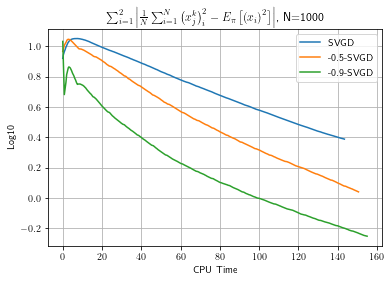

In [406]:
plt.rcParams['text.usetex'] = True
plt.plot(time-time[0],np.log10(variances),label='SVGD')
plt.plot(time1-time1[0],np.log10(variances1),label='-0.5-SVGD')
plt.plot(time2-time2[0],np.log10(variances2),label='-0.9-SVGD')
plt.legend()
plt.xlabel('CPU Time')
plt.ylabel('Log10')
plt.grid(True)
plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i^2-E_\pi\left[\left(x_i\right)^2\right]\right|$, N='+str(num_particle))
#plt.savefig('SVGD.eps')
plt.show()

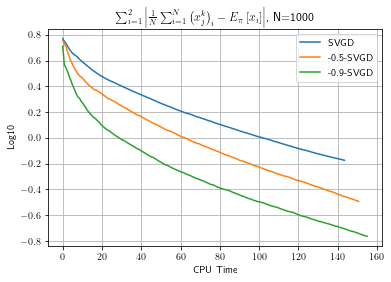

In [407]:
plt.rcParams['text.usetex'] = True
plt.plot(time-time[0],np.log10(means),label='SVGD')
plt.plot(time1-time1[0],np.log10(means1),label='-0.5-SVGD')
plt.plot(time2-time2[0],np.log10(means2),label='-0.9-SVGD')
plt.legend()
plt.xlabel('CPU Time')
plt.ylabel('Log10')
plt.grid(True)
#plt.savefig('SVGD.eps')
plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i-E_\pi\left[x_i\right]\right|$, N='+str(num_particle))
plt.show()

In [456]:
k=10
n_iter = 401
num_particle = 300
omega_p = np.zeros([k,n_iter,num_particle])
stein_p = np.zeros([k,n_iter])
for d in range(k):
   dimension= (d+1)*3
   w = np.array([1])
   mean = np.array([2]+[2 for i in range(dimension-1)])
   var = np.array([1])
    # w = np.array([0.4,0.2,0.4])
    # mean = np.array([[2]+[0 for i in range(dimension-1)],[4]+[0 for i in range(dimension-1)],[3]+[-3 for i in range(dimension-1)]])
    # var = np.array([1,1,1])

   highDimensionGM_model = highDimensionGM(dimension,w, mean, var) 
   dlnprob = highDimensionGM_model.dlnprob
   probdensity=highDimensionGM_model.MGprob
   svgd_model = SVGD_model()
   x0 = np.random.normal(0, 1, [num_particle,dimension])
   x0 = x0+np.array([0 for i in range(dimension)])

   beta =-0.5
   
   x,stein,omega,time = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.1,loop=1,tau=0.0001,opt_step = 0.3, opt_iter=40, \
                                bandwidth=dimension , debug=True,alpha=0.2,init_iter=40)
   stein_p[d]=stein
   omega_p[d]=omega




   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


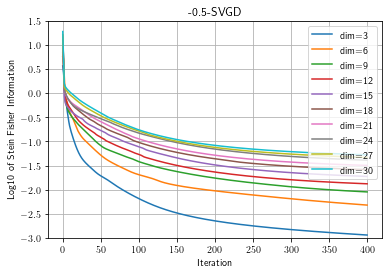

In [457]:
plt.rcParams['text.usetex'] = True
for i in range(k):
   plt.plot(np.log10(stein_p[i]),label='dim='+str((i+1)*3))

plt.legend(loc=1)
plt.xlabel('Iteration')
plt.ylabel('Log10 of Stein Fisher Information')
plt.grid(True)
plt.ylim(-3,1.5)
plt.title('-0.5-SVGD')
plt.savefig('steininfromation9SVGD.eps')
#plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i-E_\pi\left[x_i\right]\right|$, N='+str(num_particle))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


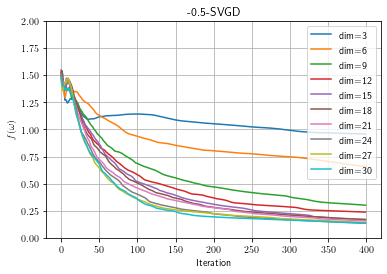

In [435]:
plt.rcParams['text.usetex'] = True
for i in range(k):
   plt.plot(((abs(omega_p-1/num_particle)).sum(2))[i][1:],label='dim='+str((i+1)*3))

plt.legend(loc=1)
plt.xlabel('Iteration')
plt.ylabel(r'$f(\omega)$')
plt.grid(True)
plt.title('-0.5-SVGD')
plt.ylim(0,2)
plt.savefig('importanceweight9SVGD.eps')
#plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i-E_\pi\left[x_i\right]\right|$, N='+str(num_particle))
plt.show()

In [411]:
num_particle = 300
n_iter = 801
loo=7
yy= np.array([10]+[10 for i in range(dimension-1)])


np.random.seed(4000)
x_ab = np.zeros([loo,n_iter])
x_ab_mean = np.zeros([loo,n_iter])

a = [9.4]+[4.6 for i in range(dimension-1)]
b= [2.8]+[-1.2 for i in range(dimension-1)]
for i in range(loo):
                    
    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    beta =-0
   
    if i==0:
        x,stein,omega,time = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=0.5,loop=20,tau=0.6,opt_step = 0.3, opt_iter=10, \
                                bandwidth=dimension , debug=True,alpha=0.1,init_iter=10)
    else:
        x,stein,omega,time = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=i,loop=20,tau=0.6,opt_step = 0.3, opt_iter=10, \
                                bandwidth=dimension , debug=True,alpha=0.1,init_iter=10)
    
    for j in range(x.shape[0]):
        x_ab[i][j]=abs(((x*x)[j]).sum(0)/x[j].shape[0]-a).sum(0)
        x_ab_mean[i][j]=abs((x)[j].sum(0)/x[j].shape[0]-b).sum(0)
# variances = (x_ab.sum(0))/loo
# means = (x_ab_mean.sum(0))/loo     




<ipython-input-402-8701455bc532>:36: RuntimeWarning: invalid value encountered in true_divide
  return num/den


KeyboardInterrupt: 

In [ ]:
num_particle = 300
n_iter = 801
loo=1
yy= np.array([10]+[10 for i in range(dimension-1)])

np.random.seed(4000)
x_ab2 = np.zeros([loo,n_iter])
x_ab_mean2 = np.zeros([loo,n_iter])

a = [9.4]+[4.6 for i in range(dimension-1)]
b= [2.8]+[-1.2 for i in range(dimension-1)]
for i in range(loo):
                    
    x0 = np.random.normal(0, 1, [num_particle,dimension])
    x0 = x0+yy

    beta =-1
    if i==0:
        x2,stein2,omega2,time2 = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=4,loop=10,tau=0.8,opt_step = 0.3, opt_iter=10, \
                                bandwidth=dimension , debug=True,alpha=0.1,init_iter=10)
    else:
        x2,stein2,omega2,time2 = svgd_model.update(x0, dlnprob, probdensity, beta, n_iter=n_iter, stepsize=i,loop=20,tau=0.6,opt_step = 0.3, opt_iter=10, \
                                bandwidth=dimension , debug=True,alpha=0.1,init_iter=10)
    for j in range(x2.shape[0]):
        x_ab2[i][j]=abs(((x2*x2)[j]).sum(0)/x2[j].shape[0]-a).sum(0)
        x_ab_mean2[i][j]=abs(x2[j].sum(0)/x2[j].shape[0]-b).sum(0)
# variances2 = (x_ab2.sum(0))/loo
# means2 = (x_ab_mean2.sum(0))/loo   

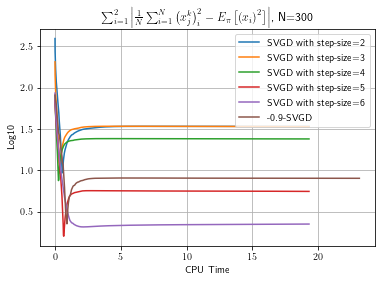

In [ ]:
plt.rcParams['text.usetex'] = True
#plt.plot(time-time[0],np.log10(x_ab[0]),label='SVGD with step-size='+str(0.5))
for i in range(1,6):
   plt.plot(time-time[0],np.log10(x_ab[i+1]),label='SVGD with step-size='+str(i+1))
#plt.plot(time1-time1[0],np.log10(variances1),label='-0.5-SVGD')
plt.plot(time2-time2[0],np.log10(x_ab2[0]),label='-0.9-SVGD')
plt.legend()
plt.xlabel('CPU Time')
plt.ylabel('Log10')
plt.grid(True)
plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i^2-E_\pi\left[\left(x_i\right)^2\right]\right|$, N='+str(num_particle))
#plt.savefig('SVGD.eps')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (801,) and (401,)

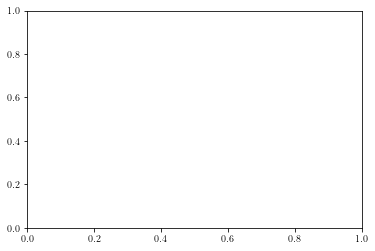

In [ ]:
plt.rcParams['text.usetex'] = True
plt.plot(time-time[0],np.log10(means),label='SVGD')
#plt.plot(time1-time1[0],np.log10(means1),label='-0.5-SVGD')
plt.plot(time2-time2[0],np.log10(means2),label='-1-SVGD')
plt.legend()
plt.xlabel('CPU Time')
plt.ylabel('Log10')
plt.grid(True)
#plt.savefig('SVGD.eps')
plt.title(r'$\sum_{i=1}^2\left|\frac{1}{N} \sum_{i=1}^N\left(x_j^k\right)_i-E_\pi\left[x_i\right]\right|$, N='+str(num_particle))
plt.show()